# Multiple Sequence Alignment & Profiles

**Authors:** [Tony Kabilan Okeke](mailto:tko35@drexel.edu)  , [Ifeanyi Osuchukwu](imo27@drexel.edu)  
Auto Template by Ahmet Sacan

You may use any function available in Matlab for this assignment. If you are using python, you may use Biopython for sequence processing and any third party package for drawing sequence logos.

In [1]:
%load_ext autoreload

In [2]:
# Imports
%autoreload 2
from Bio import SeqIO
from seqtools import fasta_removeredundants, running_mean
import matplotlib.pyplot as plt
import logomaker as lm
import pandas as pd
import numpy as np
import subprocess
import shlex
import math
import bmes

## Obtaining Homologous Sequences

This section can be done manually. You do not need to write any code for this section.

Run [`PSI-BLAST`](http://blast.ncbi.nlm.nih.gov/Blast.cgi) against non-redundant GenBank database. Use E-value of 0.1 and a maximum of 1000 target sequences. 

Download (manually, outside your code) the [`PSI-BLAST`](http://blast.ncbi.nlm.nih.gov/Blast.cgi) hits (download the aligned sequences, not the complete sequences) into a file named blastresult.fasta in this folder.

## Removing Redundant BLAST Results

BLAST will contain many similar results. You will remove this redundancy in the BLAST results to ensure some sequences/organisms do not dominate the multiple alignment analysis and to also minimize computation time in such analysis. 
 
Write a function **`fasta_removeredundants(file, identthreshold)`** that takes as input a fasta filename and produces a new file with `'.nonredundant.fasta'` appended to the input filename. E.g., if the input is `'abc.fasta'`, your function should produce the file `'abc.fasta.nonredundant.faasta'`.  
Your function should read in the entries contained in the input fasta file and remove any entry that is more than `'identthreshold'` similar to any of the entries that appear before it. E.g., if the 2nd and 5th sequences are more similar than `'identthreshold'`, you should remove the 5th sequence. Once you remove the 5th sequence, the 5th should also not be considered for any further similarity comparisons with the sequences that come after it.  

* If `'identthreshold'` is not given, use 0.95 by default.  
* When calculating the identity between two sequences, use Global Alignment with Free End Gaps.  
* Assume that the input fasta file contains protein sequences. Your function should return the fraction of the sequences that were removed.

In [3]:
# Do not change this line of code
print( "{:.2f}% of the sequences were removed.".format(fasta_removeredundants('blastresult.fasta', 0.9)*100) )

48.06% of the sequences were removed.


## Running Multiple Sequence Alignment Algorithm

Run ClustalOmega to multiple-align the sequences contained in the `blastresult.fasta.nonredundant.fasta` file (in this folder). Store the result in `malnresult.fasta` (in this folder).

Manually running the ClustalOmega outside your code is not acceptable here. You must run ClustalOmega in your code. You can rely on a `system()` call to run external commands. If you are using python, you can use `subprocess.check_output()`, `subprocess.run()` or other functions for that purpose.

In [5]:
# The following is the recommended location for the clustalo.exe.
# If you install ClustalOmega elsewhere, make sure to modify the following line
# accordingly. Do NOT install ClustalOmega in your course dropbox folder.

CLUSTALEXE = "/home/kabil/.anaconda3/envs/blast/bin/clustalo"
resultname = 'malnresult.fasta'
cmd = shlex.split( f"{CLUSTALEXE} -i blastresult.fasta.nonredundant.fasta -o {resultname}" )
process = subprocess.run(cmd, stdout=subprocess.PIPE, universal_newlines=True)

## Load the Sequences

Read in the sequences from the multiple alignment fasta file. If you are working in Matlab, it will be convenient to keep the entire alignment in a character matrix.

Remove any alignment columns that have a gap in the first sequence. After this 'cleanup', the first sequence of the multiple alignment will not have any gaps, but there may be gaps in the remaining sequences.

In [6]:
# Parse clustal omega output
raw_ptns = [ str(ptn.seq) for ptn in SeqIO.parse('malnresult.fasta', 'fasta') ]

# Keep only non-gap characters in the first sequence
keep = [ i for i in range(len(raw_ptns[0])) if raw_ptns[0][i] != '-' ]

# Remove any alignment columns that have a gap in the first sequence
cleaned_ptns = [ [aa for (i,aa) in enumerate(ptn) if i in keep] for ptn in raw_ptns ]

# Store sequences in numpy array
cleaned_ptns = np.asarray(cleaned_ptns)

## Calculate PSSM

Calculate the PSSM matrix from  the multiple alignment produced by clustalomega. Your matrix should have 20 rows and as many columns as there are in the multiple sequence alignment. Use a `pseudocount` of 1 for each amino acid type (i.e., pretend there are 20 additional fake sequences in the multiple alignment, each sequence composed of only one of the amino acid types).

In your PSSM, do not have an entry for the gap character. In each column, divide each amino acid count with the number of non-gap characters in that column. So, if you have a column with 50% A's and 50% gaps, the frequency of A should be 100% (slightly lower than 100% after pseudocount correction).

In [7]:
# Define single letter mmino acid abbreviations
aa_list = list( 'ACDEFGHIKLMNPQRSTVWY' )

# Keep track of aa frequencies for each alignment position
aa_freq = { aa:[] for aa in aa_list }

# Loop through alignment positions
for col in range( cleaned_ptns.shape[1] ):
    # Initialize amino acid counts
    aa_count = { aa:1 for aa in aa_list }
    # Get frequencies of amino acids in this column
    values, counts = np.unique(cleaned_ptns[:, col], return_counts=True)
    for aa, count in zip(values, counts):
        if aa in aa_list:
            aa_count[aa] += count
    # Store amino acid frequencies
    for aa in aa_list:
        aa_freq[aa].append( aa_count[aa] / sum(aa_count.values()) )

# Create pssm
pssm = pd.DataFrame.from_dict(aa_freq, orient='index')

## Hydrophobicity Plot

Add up the PSSM frequencies of hydrophobic amino acids (VILMFWC) and plot their total frequency over the entire length of the multiple alignment.

In [8]:
# Extract hyrdophobic amino acids from pssm
hydrophobic = pssm.loc[ list('VILMFWC') ]

# Define total frequency
hydro_ratio = hydrophobic.sum(axis=0).tolist()
residue_pos = list(hydrophobic.columns)

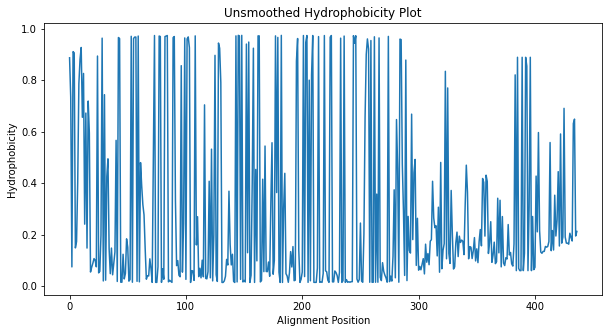

In [9]:
# Unsmoothed Hydrophobicity Plot
plt.figure(figsize=(10,5))
plt.plot(residue_pos, hydro_ratio)
plt.title("Unsmoothed Hydrophobicity Plot")
plt.xlabel("Alignment Position")
plt.ylabel("Hydrophobicity");

Using moving window averaging method, smooth out the hydrophobicity values. You will need to select the window size yourself. Small window sizes (around 3-5 residues) would average local regions, whereas large window size (around 100-500 residues will highlight larger domain properties).  

Plot the smoothed entropy values over the entire length of the multiple alignment. To smooth a vector, you can use `movmean()` in Matlab. In python, you can use `convolve()` or other approaches listed [here](https://stackoverflow.com/questions/13728392/moving-average-or-running-mean).  
Make sure to cite any code-block you borrow from other sources.

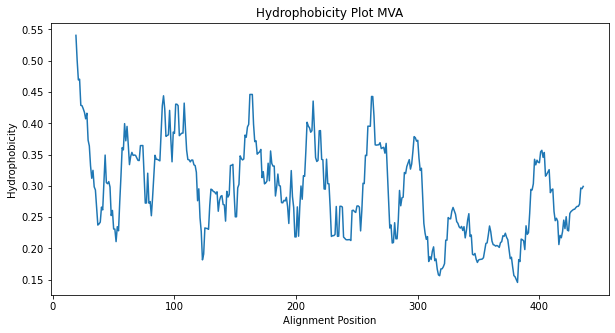

In [10]:
# Smooth Data
N = 20
mva_hydro = running_mean(hydro_ratio, N)

# Smoothed Hydrophobicity plot
plt.figure(figsize=(10,5))
plt.plot(residue_pos[N-1:], mva_hydro)
plt.title("Hydrophobicity Plot MVA")
plt.xlabel("Alignment Position")
plt.ylabel("Hydrophobicity");

Which part of the multiple alignment is composed of more hydrophilic amino acids? Use visual inspection of the smoothed hydrophobicity plot. You may need to adjust the smoothing window size above to support your claim.  
Use code in combination with comments/fprintf to answer this question.

In [11]:
# Most Hydrophilic = Minimum hydrophobic rergion
pos = np.argmin(mva_hydro) + N-1
print('Most hydrophilic region is around alignment position {:d}.'.format(pos))

Most hydrophilic region is around alignment position 382.


## Calculate Entropy

Calculate entropy of each alignment column from the PSSM. No need to worry about $log_2(0)$ being `NaN`, because we have added pseudo-counts, which make sure there is no zero in the PSSM matrix.

No need to worry about `NaN`, because we have added pseudo-counts.

Using moving window averaging method, smooth out the entropy values. You need to select the window size yourself. Plot the smoothed entropy values over the entire length of the multiple alignment.

In [12]:
# Compute entropy for each alignment position
entropy = []
for i in pssm.columns:
    # Calculate entropy for each amino acid in column
    aa_freq = pssm[i]
    entropy.append( [ -fc*math.log(fc,2) for fc in aa_freq ] )

# Total entropy for each column
entropy = [ sum(ent_col) for ent_col in entropy ]

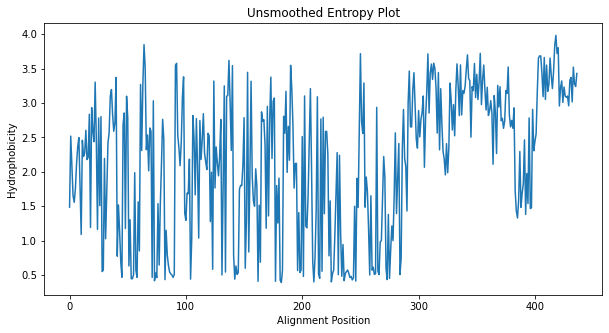

In [13]:
# Unsmoothed Entropy Plot
plt.figure(figsize=(10,5))
plt.plot(residue_pos, entropy)
plt.title("Unsmoothed Entropy Plot")
plt.xlabel("Alignment Position")
plt.ylabel("Hydrophobicity");

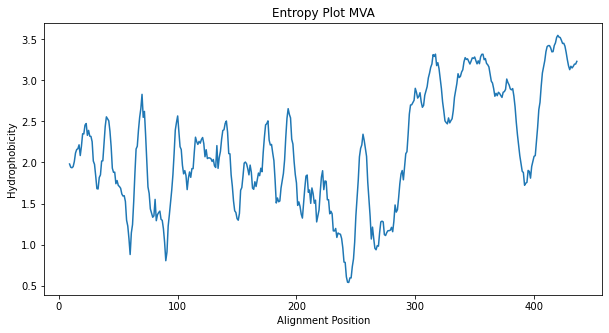

In [18]:
# Smooth Data
N = 10
mva_entropy = running_mean(entropy, N)

# Smoothed Hydrophobicity plot
plt.figure(figsize=(10,5))
plt.plot(residue_pos[N-1:], mva_entropy)
plt.title("Entropy Plot MVA")
plt.xlabel("Alignment Position")
plt.ylabel("Hydrophobicity");

Identify the 'region' of the multiple alignment that is most conserved. Assume a 'region' is defined by the same window definition used to smooth the entropy values above. 

Use the smoothed entropy values to answer this question. You may need to adjust the smoothing window size to support your interpretation. Use code in combination with comments to answer this question.

In [15]:
# Compute total entropies for each possible window
conserved2 = { (i,i+N): sum(mva_entropy[i:i+N]) for i in range(len(mva_entropy)-N) }
# Identify most conserved (least entropy) window
conserved2 = min(conserved2, key=conserved2.get)
# Define boundaries for most conserved region
res1, res2 = ( i+N-1 for i in conserved2 )

print( f"Most conserved region is between positions {res1} and {res2} of the alignment." )

Most conserved region is between positions 239 and 249 of the alignment.


## Sequence Logo

Display a sequence logo of the multiple alignment, centered around the most conserved region you identified above. The size of your sequence logo should be around 10-20 residues. Create a readable figure that highlights the conserved residues.

In [16]:
# Initialize dictionary to store Information values
aa_info = { aa:[] for aa in aa_list }

# Compute conservation values
for i in range(len(entropy)):
    col_factor = math.log(20, 2) - entropy[i]
    info = [ fc*col_factor for fc in pssm[i] ]
    for k in range(len(info)):
        aa_info[ aa_list[k] ].append(info[k])

# Store sequence profile in dataframe
seq_profile = pd.DataFrame.from_dict(aa_info)

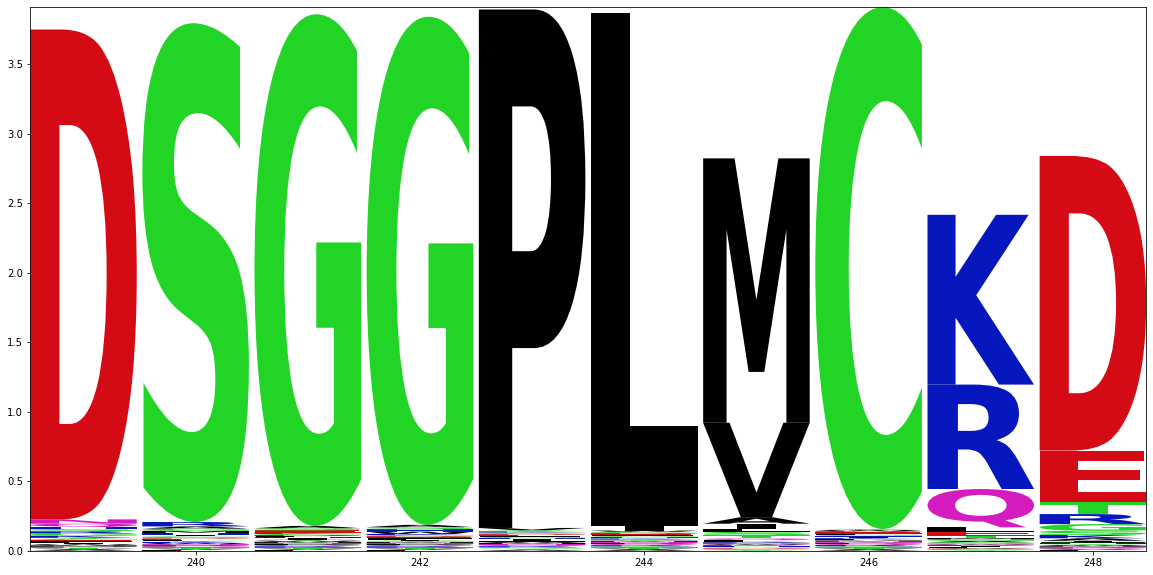

In [17]:
# Sequence Logo
lm.Logo(seq_profile.iloc[res1:res2], figsize=(20,10));